In [1]:
using Plots; gr(); # Using the Plotly Backend
using Printf
using Random, Distributions

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273


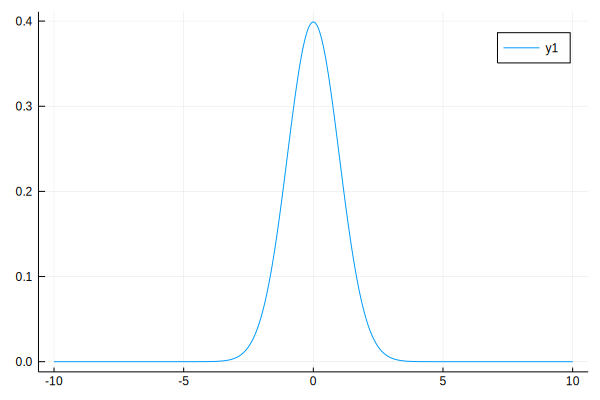

In [2]:
gaussian(x, μ, v) = exp.(-0.5*(x.-μ).^2/v)/sqrt(2.0 *π*v)
x = collect(-10:.01:10)
y = gaussian(x, 0.0, 1.0)
plot(x, y)

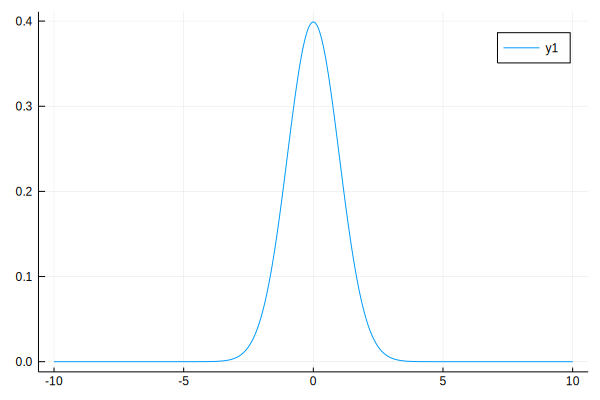

In [4]:
g = Normal(0, 1);
z = [ pdf(g, xx) for xx in x ]
plot(x, z)

In [5]:
function gaussian_prod(g1, g2)
    v1 = (g1.σ)^2
    v2 = (g2.σ)^2
    return Normal((v2*g1.μ + v1*g2.μ)/(v1+v2), sqrt(v1*v2/(v1+v2)))
end

function gaussian_sum(g1, g2)
    v1 = (g1.σ)^2
    v2 = (g2.σ)^2
    return Normal((g2.μ + g1.μ), sqrt(v2 + v1))
end

gaussian_sum (generic function with 1 method)

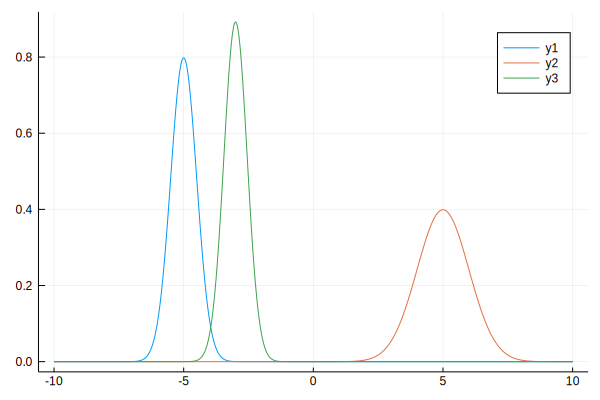

In [6]:
n1 = Normal(-5, .5)
n2 = Normal(5, 1)
p = gaussian_prod(n1, n2)
z = [ pdf(n1, xx) for xx in x ]
plot(x, z)
z = [ pdf(n2, xx) for xx in x ]
plot!(x, z)
z = [ pdf(p, xx) for xx in x ]
plot!(x, z)

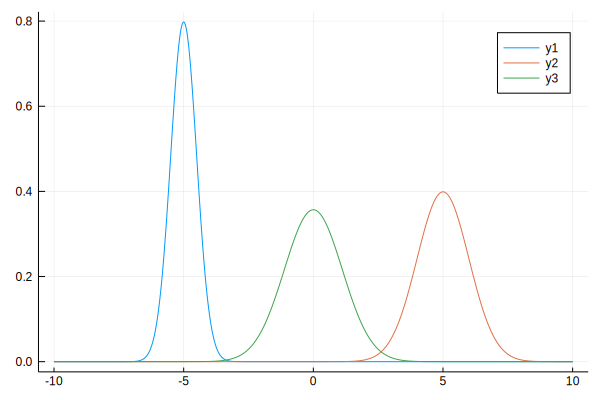

In [7]:
n1 = Normal(-5, .5)
n2 = Normal(5, 1)
p = gaussian_sum(n1, n2)
z = [ pdf(n1, xx) for xx in x ]
plot(x, z)
z = [ pdf(n2, xx) for xx in x ]
plot!(x, z)
z = [ pdf(p, xx) for xx in x ]
plot!(x, z)

In [8]:
predicted_pos = Normal(10, .2)
measured_pos = Normal(11, .1)
estimated_pos = gaussian_prod(predicted_pos, measured_pos)

Normal{Float64}(μ=10.799999999999999, σ=0.0894427190999916)

In [9]:
pos = Normal(10, .2)
move = Normal(15, .7)
gaussian_sum(pos, move)

Normal{Float64}(μ=25.0, σ=0.7280109889280517)

In [10]:
mutable struct Model
    x::Float64
    g_x::Normal
    g_v::Normal
    function Model(x, g_x, g_v)
        new(x, g_x, g_v)
    end
end

function update_model(model, dt)
    dx = rand(model.g_v)
    # @printf("dx: %f\n", dx)
    model.x += dx*dt
    # @printf("predict x: %f\n", model.x)
    rand_meas = rand(model.g_x)
    # @printf("rand meas x: %f\n", rand_meas)
    meas = model.x + rand_meas
    # @printf("meas x: %f\n", meas)
    return meas
end

update_model (generic function with 1 method)

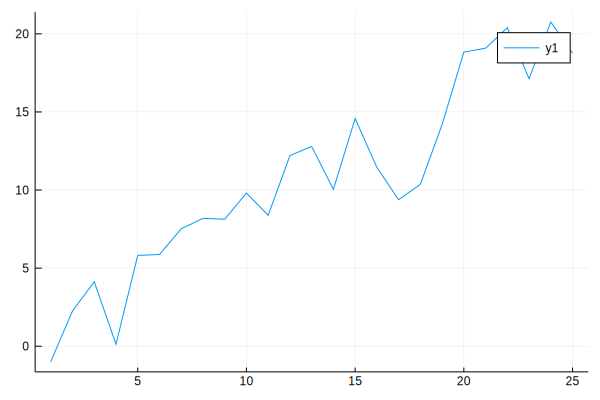

In [11]:
process_σ = sqrt(2) # 2
sensor_σ = sqrt(4.5) # 4.5
process_g = Normal(1, sqrt(process_σ))
sensor_g = Normal(0, sensor_σ)
N = 25

x = Normal(0, sqrt(400))

model = Model(mean(x), sensor_g, process_g)
z = [ update_model(model, 1) for _ in 1:1:N ];
plot(z)

In [12]:
predict(pos, movement) = gaussian_sum(pos, movement)
update(prior, likelihood) = gaussian_prod(prior, likelihood)

update (generic function with 1 method)

In [13]:
# likelihood: 25.39 (2.12)
# [25.39] prior: 3.46 (0.21), x: 3.67 (0.21)

update(Normal(25.39, 2.12), Normal(3.46, 0.21))

Normal{Float64}(μ=3.673090889060262, σ=0.2089772384108996)

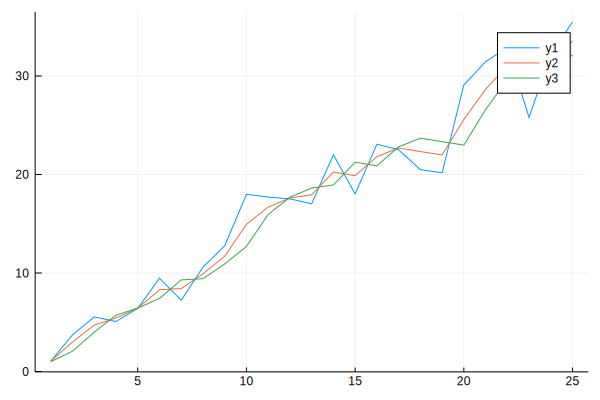

In [14]:
process_σ = sqrt(2) # 2
sensor_σ = sqrt(4.5) # 4.5
process_g = Normal(1, sqrt(process_σ))
sensor_g = Normal(0, sensor_σ)
N = 25

x = Normal(0, sqrt(400))

model = Model(mean(x), sensor_g, process_g)
z = [ update_model(model, 1) for _ in 1:1:N ];

filter = []
priors = []
for d in z
    prior = predict(x, process_g)
    push!(priors, prior)
    likelihood = Normal(d, sensor_σ)
    # @printf("likelihood: %.02f (%.02f)\n", likelihood.μ, likelihood.σ)
    x = update(prior, likelihood)
    # @printf("[%.02f] prior: %.02f (%.02f), x: %.02f (%.02f)\n", d, prior.μ, prior.σ, x.μ, x.σ)
    push!(filter, x)
end

μfilter = [i.μ for i in filter];
μpriors = [i.μ for i in priors];
σfilter = [i.σ for i in filter];
σpriors = [i.σ for i in priors];
plot(z)
plot!(μfilter)
plot!(μpriors)

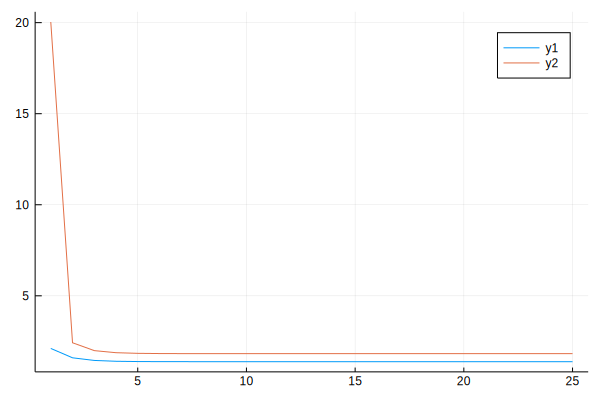

In [15]:
plot(σfilter)
plot!(σpriors)

In [16]:
function update(prior, measurement)
    x, P = prior.μ, prior.σ^2               # mean and variance of prior
    z, R = measurement.μ, measurement.σ^2   # mean and variance of measurement
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return Normal(x, sqrt(P))
end

update (generic function with 1 method)

In [17]:
function predict(posterior, movement)
    x, P = posterior.μ, posterior.σ^2 # mean and variance of posterior
    dx, Q = movement.μ, movement.σ^2 # mean and variance of movement
    x = x + dx
    P = P + Q
    return Normal(x, sqrt(P))
end

predict (generic function with 1 method)

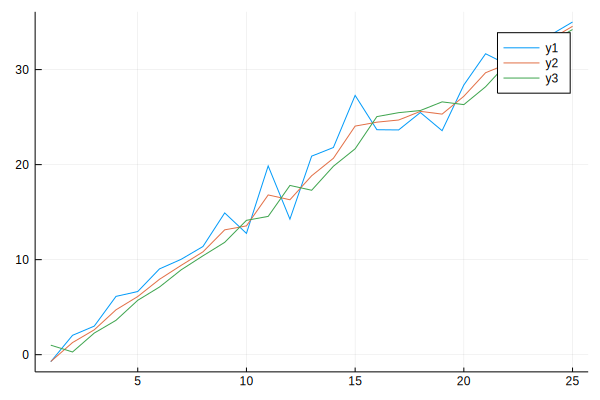

In [18]:
process_σ = sqrt(2) # 2
sensor_σ = sqrt(4.5) # 4.5
process_g = Normal(1, sqrt(process_σ))
sensor_g = Normal(0, sensor_σ)
N = 25

x = Normal(0, sqrt(400))

model = Model(mean(x), sensor_g, process_g)
z = [ update_model(model, 1) for _ in 1:1:N ];

filter = []
priors = []
for d in z
    prior = predict(x, process_g)
    push!(priors, prior)
    likelihood = Normal(d, sensor_σ)
    # @printf("likelihood: %.02f (%.02f)\n", likelihood.μ, likelihood.σ)
    x = update(prior, likelihood)
    # @printf("[%.02f] prior: %.02f (%.02f), x: %.02f (%.02f)\n", d, prior.μ, prior.σ, x.μ, x.σ)
    push!(filter, x)
end

μfilter = [i.μ for i in filter];
μpriors = [i.μ for i in priors];
σfilter = [i.σ for i in filter];
σpriors = [i.σ for i in priors];
plot(z)
plot!(μfilter)
plot!(μpriors)